we saw that the model dont work as expected for new data. we will tarin the model with the new data.

In [38]:
# Import Libraries
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import random


In [39]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [40]:
# Load the preprocessed data from CSV files
new_data = pd.read_csv("WELFake_Dataset.csv")

# split the new data into train and test
new_train_data, new_test_data = train_test_split(new_data, test_size=0.2)

# split to train and validation
new_train_data, new_val_data = train_test_split(new_train_data, test_size=0.2)

X_train = new_train_data['text']
X_train = pd.Series(X_train).fillna("").tolist()
y_train = new_train_data['label']

X_val = new_val_data['text']
X_val = pd.Series(X_val).fillna("").tolist()
y_val = new_val_data['label']

X_test = new_test_data['text']
X_test = pd.Series(X_test).fillna("").tolist()
y_test = new_test_data['label']

In [41]:
original_state = torch.load('best_mlp_model.pth')


C:\Users\dell\AppData\Local\Temp\ipykernel_13884\3045954509.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_state = torch.load('best_mlp_model.pth')


In [42]:
# Get the original embedding weights
original_embedding_weights = original_state['embedding.weight']
original_vocab_size = original_embedding_weights.shape[0]

# Create vocabulary with same words as original model
embedding_dim = 300
vocab = {"<PAD>": 0, "<UNK>": 1}  # Special tokens
embedding_matrix = [np.zeros(embedding_dim), np.random.uniform(-0.01, 0.01, embedding_dim)]


In [43]:
# Load pre-trained Word2Vec model
word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)


In [44]:
# First add all words from original embedding matrix
for i in range(2, original_vocab_size):  # Skip PAD and UNK tokens
    word_vector = original_embedding_weights[i].numpy()
    # Add placeholder word to maintain same indices as original model
    vocab[f"word_{i}"] = len(vocab)
    embedding_matrix.append(word_vector)

# Now build additional vocabulary from new data
for text in X_train:
    for word in text.split():
        if word not in vocab and word in word2vec:
            vocab[word] = len(vocab)
            embedding_matrix.append(word2vec[word])

embedding_matrix = np.array(embedding_matrix)
vocab_size = len(vocab)

print(f"Original vocabulary size: {original_vocab_size}")
print(f"New vocabulary size: {vocab_size}")

Original vocabulary size: 76131
New vocabulary size: 203269


In [45]:
# Tokenize and convert text to sequences
def text_to_sequence(text, vocab, max_len=1000):
    sequence = [vocab.get(word, vocab["<UNK>"]) for word in text.split()]
    if len(sequence) < max_len:
        sequence.extend([vocab["<PAD>"]] * (max_len - len(sequence)))
    return sequence[:max_len]

# Apply tokenization
max_len = 1000

In [46]:
def augment_text(text):
    words = text.split()
    # Randomly drop some words (with 20% probability)
    words = [w for w in words if random.random() > 0.2]
    # If we dropped all words (unlikely but possible), return original text
    if not words:
        return text
    return ' '.join(words)

# Custom Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, is_training=False):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)
        self.is_training = is_training
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        if self.is_training:
            # Get the original sequence
            sequence = self.texts[idx].tolist()  # Convert tensor to list
            # Remove padding tokens for augmentation
            sequence = [x for x in sequence if x != vocab["<PAD>"]]
            # Augment
            if len(sequence) > 0:  # Only augment if we have tokens
                sequence = [x for x in sequence if random.random() > 0.2]
            # Re-pad the sequence
            if len(sequence) < max_len:
                sequence.extend([vocab["<PAD>"]] * (max_len - len(sequence)))
            sequence = sequence[:max_len]
            # Convert back to tensor
            text = torch.tensor(sequence, dtype=torch.long)
        else:
            text = self.texts[idx]
            
        return text, self.labels[idx]

In [47]:
class MLPModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dims=[512, 256, 128], output_dim=1):
        super(MLPModel, self).__init__()
        
        # Embedding Layer with frozen weights
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True,
            padding_idx=0
        )
        
        # Calculate input dimension
        input_dim = embedding_matrix.shape[1] * max_len
        
        # Create list to hold all layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.LayerNorm(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))
        
        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.LayerNorm(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        # Combine all layers
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        # Get embeddings and flatten
        embedded = self.embedding(x)
        flattened = embedded.view(embedded.size(0), -1)
        
        # Forward pass through all layers
        return self.model(flattened)

In [48]:
# Create model with new embedding matrix
model = MLPModel(
    embedding_matrix=embedding_matrix,
    hidden_dims=[256, 128, 64],
    output_dim=1
).to(device)

# Create a new state dict that will contain the updated parameters
new_state_dict = {}

# Copy over the original embedding weights for the words that existed in the original model
new_embedding_weight = model.embedding.weight.data.clone()
original_embedding_weights = original_state['embedding.weight']
new_embedding_weight[:original_vocab_size] = original_embedding_weights

# Update the embedding layer with the combined weights
model.embedding.weight.data.copy_(new_embedding_weight)

# Copy over the weights for all other layers
for name, param in original_state.items():
    if 'embedding' not in name:
        new_state_dict[name] = param

# Load the non-embedding weights
model.load_state_dict(new_state_dict, strict=False)

# Verify the model loaded correctly
print("Model loaded successfully!")
print(f"Embedding layer shape: {model.embedding.weight.shape}")
print(f"First few indices match original:", 
      torch.allclose(model.embedding.weight[:original_vocab_size], original_embedding_weights))

Model loaded successfully!
Embedding layer shape: torch.Size([203269, 300])
First few indices match original: True


## Start fine tuning the model

In [49]:
def evaluate_model(model, data_loader, criterion):
    """
    Evaluate the model on validation/test set
    """
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    
    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            labels = labels.float().to(device)
            
            outputs = model(texts).squeeze(-1)
            
            if len(outputs.shape) == 0:
                outputs = outputs.unsqueeze(0)
            if len(labels.shape) == 0:
                labels = labels.unsqueeze(0)
                
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [50]:
def fine_tune_model(model, train_loader, val_loader, epochs=15, learning_rate=1e-5):
    """
    Fine-tune the model with a smaller learning rate and frozen embedding layer
    """
    # Lists to store metrics
    loss_training_values = []
    loss_validation_values = []
    acc_training_values = []
    acc_validation_values = []
    
    # Keep embedding layer frozen
    for param in model.embedding.parameters():
        param.requires_grad = False
        
    # Unfreeze last few layers for fine-tuning
    for param in model.model[-4:].parameters():  # Unfreeze last layer and the one before it
        param.requires_grad = True
    
    # Calculate class weights for imbalanced dataset
    num_pos = sum(y_train == 1)
    num_neg = sum(y_train == 0)
    pos_weight = torch.tensor([num_neg / num_pos]).to(device)
    
    # Use binary cross entropy loss with class weights
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    # Use a smaller learning rate for fine-tuning
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate,
        weight_decay=0.01
    )
    
    # Learning rate scheduler with warm-up
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=2,
        verbose=True
    )
    
    best_val_loss = float('inf')
    best_model_state = None
    patience = 4
    patience_counter = 0
    
    num_warmup_steps = 100
    def get_lr(step):
        if step < num_warmup_steps:
            return learning_rate * (step / num_warmup_steps)
        return learning_rate
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for i, (texts, labels) in enumerate(train_loader):
            # Apply learning rate warmup
            current_lr = get_lr(epoch * len(train_loader) + i)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
                
            texts = texts.to(device)
            labels = labels.float().to(device)
            
            optimizer.zero_grad()
            outputs = model(texts).squeeze(-1)
            
            # Ensure shapes match
            if len(outputs.shape) == 0:
                outputs = outputs.unsqueeze(0)
            if len(labels.shape) == 0:
                labels = labels.unsqueeze(0)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            total_loss += loss.item()
            
            if i % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item():.4f}')
        
        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        
        # Store training metrics
        loss_training_values.append(avg_loss)
        acc_training_values.append(train_acc)
        
        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        
        # Store validation metrics
        loss_validation_values.append(val_loss)
        acc_validation_values.append(val_acc)
        
        print(f'Epoch: {epoch}')
        print(f'Average Loss: {avg_loss:.4f}')
        print(f'Training Accuracy: {train_acc:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f}')
        
        scheduler.step(val_acc)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            torch.save(best_model_state, 'fine_tuned_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print('Early stopping triggered')
            model.load_state_dict(best_model_state)
            break
    
    return model, loss_training_values, loss_validation_values, acc_training_values, acc_validation_values


In [51]:
# apply tokenization to the test data
X_train_seq = [text_to_sequence(text, vocab, max_len) for text in X_train]
X_val_seq = [text_to_sequence(text, vocab, max_len) for text in X_val]
X_test_seq = [text_to_sequence(text, vocab, max_len) for text in X_test]

# Create new dataloaders with the WELFake dataset
train_dataset = TextDataset(X_train_seq, y_train, is_training=True)
val_dataset = TextDataset(X_val_seq, y_val, is_training=False)
test_dataset = TextDataset(X_test_seq, y_test, is_training=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [52]:
# After training, plot the metrics
def plot_metrics(loss_training_values, loss_validation_values, acc_training_values, acc_validation_values):
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(loss_training_values, label='Training Loss')
    plt.plot(loss_validation_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(acc_training_values, label='Training Accuracy')
    plt.plot(acc_validation_values, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


c:\Users\dell\OneDrive - Ariel University\Desktop\a\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 0, Batch: 0, Loss: 0.3401
Epoch: 0, Batch: 100, Loss: 0.8255
Epoch: 0, Batch: 200, Loss: 0.7755
Epoch: 0, Batch: 300, Loss: 0.4194
Epoch: 0, Batch: 400, Loss: 0.1237
Epoch: 0, Batch: 500, Loss: 0.2242
Epoch: 0, Batch: 600, Loss: 0.2267
Epoch: 0, Batch: 700, Loss: 0.2208
Epoch: 0, Batch: 800, Loss: 0.5647
Epoch: 0, Batch: 900, Loss: 0.1435
Epoch: 0, Batch: 1000, Loss: 0.5939
Epoch: 0, Batch: 1100, Loss: 0.1537
Epoch: 0, Batch: 1200, Loss: 0.1365
Epoch: 0, Batch: 1300, Loss: 0.1393
Epoch: 0, Batch: 1400, Loss: 0.2045
Epoch: 0
Average Loss: 0.3443
Training Accuracy: 0.8788
Validation Loss: 0.2855
Validation Accuracy: 0.8785
Epoch: 1, Batch: 0, Loss: 0.1974
Epoch: 1, Batch: 100, Loss: 0.4029
Epoch: 1, Batch: 200, Loss: 0.0791
Epoch: 1, Batch: 300, Loss: 0.2084
Epoch: 1, Batch: 400, Loss: 0.2101
Epoch: 1, Batch: 500, Loss: 0.1891
Epoch: 1, Batch: 600, Loss: 0.3473
Epoch: 1, Batch: 700, Loss: 0.1325
Epoch: 1, Batch: 800, Loss: 0.3357
Epoch: 1, Batch: 900, Loss: 0.0785
Epoch: 1, Batch:

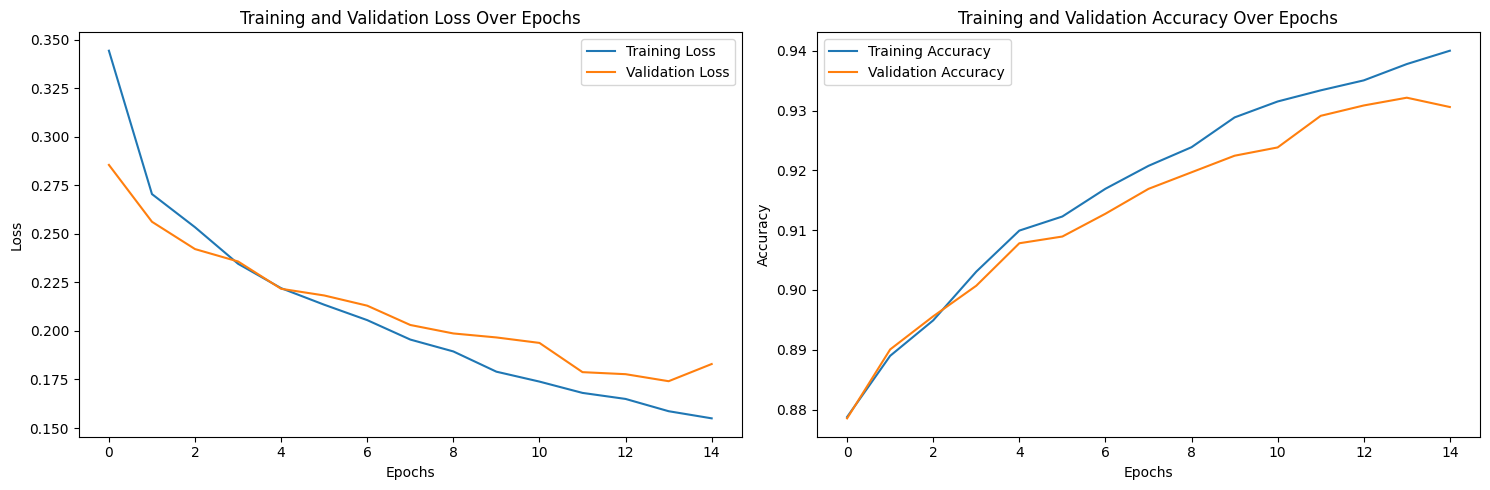

In [53]:
model, loss_train, loss_val, acc_train, acc_val = fine_tune_model(model, train_loader, val_loader, epochs=15)
plot_metrics(loss_train, loss_val, acc_train, acc_val)